In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
from ast import literal_eval
import tensorflow as tf

In [12]:
df = pd.read_csv('../data/soft_skills.csv')

In [13]:
df.head()

,text,soft_skills
0,Supervises financial management and administr...,"['instructing', 'communication', 'mediation']"
1,Serves as member of management team participa...,"['mediation', 'organization', 'coordination']"
2,Directs and oversees the company's financial ...,"['mediation', 'coordination', 'communication']"
3,Directs and oversees the annual budgeting pro...,"['coordination', 'mediation', 'instructing']"
4,Prepares external and internal financial mana...,"['mediation', 'communication', 'coordination']"


In [14]:
df.shape

(6669, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6669 entries, 0 to 6668
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         6669 non-null   object
 1   soft_skills  6669 non-null   object
dtypes: object(2)
memory usage: 104.3+ KB


In [16]:
from ast import literal_eval

df["soft_skills"] = df["soft_skills"].apply(
    lambda x: literal_eval(x)
)

df["soft_skills"].values[:5]

array([list(['instructing', 'communication', 'mediation']),
       list(['mediation', 'organization', 'coordination']),
       list(['mediation', 'coordination', 'communication']),
       list(['coordination', 'mediation', 'instructing']),
       list(['mediation', 'communication', 'coordination'])], dtype=object)

In [17]:
class_counts = df["soft_skills"].value_counts()

In [18]:
# Get the names of the classes that have at least two samples.
from sklearn.model_selection import train_test_split

valid_classes = class_counts[class_counts >= 2].index.tolist()

# Filter the DataFrame to include only the valid classes.
df_filtered = df[df["soft_skills"].isin(valid_classes)]

# Split the filtered DataFrame into training and testing sets.
train_df, test_df = train_test_split(
    df_filtered,
    test_size= 0.2,
    random_state=42,
    stratify=df_filtered["soft_skills"].values
)

In [48]:
terms = tf.ragged.constant(train_df["soft_skills"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

## saving vocab
import pickle
with open('../data/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
    

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'mediation', 'coordination', 'communication', 'instructing', 'service orientation', 'organization', 'adaptability', 'stress management', 'time management', 'complex problem solving', 'monitoring', 'active listening', 'critical thinking', 'flexibility', 'professionalism', 'initiative', 'social perceptiveness', 'conflict resolution', 'self-motivation', 'self-awareness', 'emotional intelligence']


In [20]:
sample_label = train_df["soft_skills"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['mediation', 'coordination', 'instructing']
Label-binarized representation: [[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    5183.000000
mean       15.103608
std        12.069778
min         1.000000
25%         9.000000
50%        12.000000
75%        18.000000
max       325.000000
Name: text, dtype: float64

In [22]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["soft_skills"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [23]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(test_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [24]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b' Develop project implementation, monitoring and evaluation plans andcoordinate the implementation process of IOM CT projects as assigned; '
Label(s): ['mediation' 'coordination' 'communication']
 
Abstract: b' Develop informational products to support the Program, such aswebsite, newsletter, fact sheet, brochure, etc.;'
Label(s): ['mediation' 'communication' 'instructing']
 
Abstract: b' Performing any other activities deemed necessary.Expected OutputThe key expected output of incumbents services is the timely andqualified delivery of the project outputs as per the approved projectdocument and the work plan.Development of Java Web ApplicationsManagement DutiesDevelops and maintains donor profile software. Develops and implementsinformation systems for improving dissemination to donors (including theDiaspora).Develops and updates the Information Communications Plan and proposesand implements state'
Label(s): ['mediation' 'coordination' 'communication']
 
Abstract: b' Writing

In [25]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

11220


In [26]:
from tensorflow.keras import layers

text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [27]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/20
41/41 [==============================] - 1s 22ms/step - loss: 0.2254 - binary_accuracy: 0.9165 - val_loss: 0.1354 - val_binary_accuracy: 0.9494
Epoch 2/20
41/41 [==============================] - 1s 21ms/step - loss: 0.0704 - binary_accuracy: 0.9766 - val_loss: 0.1197 - val_binary_accuracy: 0.9560
Epoch 3/20
41/41 [==============================] - 1s 19ms/step - loss: 0.0298 - binary_accuracy: 0.9916 - val_loss: 0.1335 - val_binary_accuracy: 0.9558
Epoch 4/20
41/41 [==============================] - 1s 19ms/step - loss: 0.0155 - binary_accuracy: 0.9963 - val_loss: 0.1505 - val_binary_accuracy: 0.9564
Epoch 5/20
41/41 [==============================] - 1s 20ms/step - loss: 0.0109 - binary_accuracy: 0.9976 - val_loss: 0.1593 - val_binary_accuracy: 0.9557
Epoch 6/20
41/41 [==============================] - 1s 19ms/step - loss: 0.0078 - binary_accuracy: 0.9982 - val_loss: 0.1740 - val_binary_accuracy: 0.9564
Epoch 7/20
41/41 [==============================] - 1s 19ms/step - los

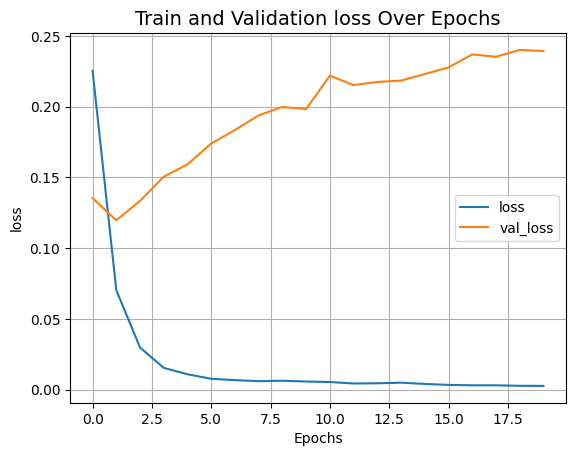

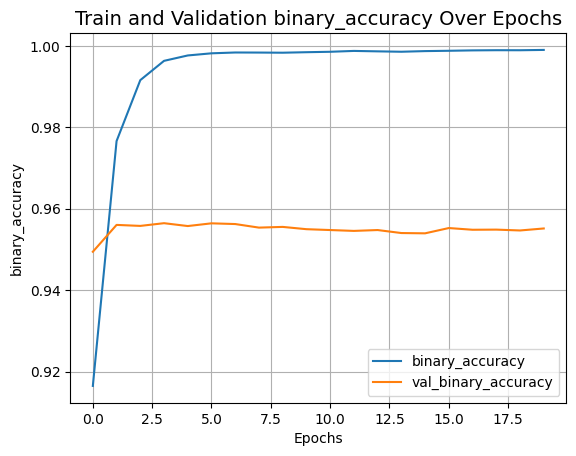

In [28]:
from tensorflow import keras

epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [29]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 8ms/step - loss: 0.2394 - binary_accuracy: 0.9551
Categorical accuracy on the test set: 95.51%.


In [36]:
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 4ms/step
Abstract: b' Retain and develop specialist knowledge on specialist areas oftranslation;'
Label(s): ['coordination' 'communication' 'instructing']
Predicted Label(s): (communication, coordination, instructing)
 
Abstract: b' Provide oversight of the transition to local ownership and coordinateactivities ensuring that implementation matches with the strategies setearlier.The main responsibility is to secure the amountof the hotel reservations by creating warm, friendly business partners(tour agences, Embasses, Consulates, Int. organizations etc.).The Loan Promoter recruits clients, offers themMDF'
Label(s): ['mediation' 'coordination' 'communication']
Predicted Label(s): (mediation, coordination, communication)
 
Abstract: b' Monitor and update furniture stock and accurately deliver orders tofactory;'
Label(s): ['communication' 'service orientation']
Predicted Label(s): (instructing, communication, service orientation)
 
Abstract: b' Con

In [7]:
import pickle
import keras
import numpy as np


def makePredictions(text):
    vocab = pickle.load(open("models/vocab.pkl", "rb"))
    model = keras.models.load_model("models/model_for_inference")
    predictions = model.predict([text])
    top_3 = np.argsort(predictions[0])[-3:][::-1]
    return [vocab[i] for i in top_3]
print(makePredictions("I am a good team player and I am a good communicator"))     

1/1 [==============================] - 0s 61ms/step
['mediation', 'service orientation', 'instructing']


In [31]:
## Save the model
model_for_inference.save("model_for_inference")

INFO:tensorflow:Assets written to: model_for_inference/assets


In [43]:
## Load the model
model_for_inference = keras.models.load_model("model_for_inference")

## Predict on new data
sent = ["I am a good team player and I am a good communicator"]
prob = model_for_inference.predict(sent)
print(prob)

1/1 [==============================] - 0s 62ms/step
[[4.8173070e-13 6.7643231e-01 2.4146592e-02 3.0335234e-03 2.7616626e-01
  6.5445590e-01 5.1552961e-05 7.7602564e-04 3.0027493e-03 2.6670587e-04
  2.5745014e-06 8.0006856e-07 2.9013802e-07 2.5444886e-06 2.0291343e-07
  1.7184618e-11 2.1751422e-11 5.7978933e-10 3.0386638e-11 1.3347221e-11
  3.5447402e-11 1.1357863e-11]]


In [35]:
labels = for 

[array([], dtype='<U23'), array([], dtype='<U23')]